## 3. Exercise - Natalie Auer (6.12.2022) {-}

In [624]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.signal
import scipy.stats
import xarray as xr
#import pymannkendall as mk
import copy
import os
import pymannkendall as mk

import warnings
warnings.filterwarnings("ignore")
import dask
from dask.diagnostics import progress
import intake
from collections import defaultdict
import random
import matplotlib.cm as cm

import git
from git.repo.base import Repo

import cartopy.crs as ccrs
from sklearn.decomposition import PCA

#### 1) First steps on GitHub {-}
Open a GitHub account (if you don’t have one yet). Set up a new online repository following the
instructions on GitHub. Add a README file, LICENSE and .gitignore. Create a branch called
Exercise_3. Clone the repository from the hosted location to your directory on the Teaching
Hub via the URL (it will ask for your password, use a generated on GitHub token instead).
Hint: You can find useful git commands here: git-cheat-sheet-education.pdf.

In [529]:
pip install GitPython

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [531]:
#Repo.clone_from("https://github.com/a11920398/Modelling_UE.git", "3 Exercise")

In [532]:
!ls

 1_Exercise.ipynb	 global_mean_data.nc	 __pycache__
 2_Exercise.ipynb	 global_mean_models.nc	 sc_1.png
'3 Exercise'		 https:			 sc_2.png
 3_Exercise.ipynb	 MODELLING		 sc_3.png
 ERA5_EX3.nc		 models_mean_data.nc	 Untitled.ipynb
 function_plot_ex3.py	 my_IITM_ESM.pickle
 Garo_3_Exercise.ipynb	 old.ipynb


##### What do the commands commit, push and pull mean?

##### commit:
- adding changes to the local repository
- commit your staged content as a new commit snapshot
- is used in connection with your local repository
Think of a git commit as a snapshot that make up a file system. When you commit, you save your project, and Git records the work by taking a snapshot of the metadata and saving it in the local repository.

##### push:
- to transfer the last commit(s) to a remote server
- updates remote refs along with associated objects
- is used to interact with a remote repository
Transmit local branch commits to the remote repository branch.
Push the specified branch to , along with all of the necessary commits and internal objects. This creates a local branch in the destination repository.

##### pull:
- fetch and merge any commits from the tracking remote branch
- is used to access the changes (commits)from a remote repository to the local repositor
- The git pull command is used to fetch and download content from a remote repository and immediately update the local repository to match that content. 

---

#### 2) Map plots {-}
Use the ERA5 data from Exercise 1 and from any 4 CMIP6 historical models to plot maps of the
climatological mean 2 meter temperature from 1970 to 2014. Compare the CMIP6 models with
ERA5 by plotting their difference and indicate the RMSE and bias. Put the plotting routine
in a function and document it with a docstring. Then put it in a .py file. To show the plots,
import the function in a notebook or another .py file and use it there. Commit the plotting
function to your new git repository with a meaningful message and push.
You can find 3D CMIP6 data here:

/scratch/shared/comp_met_ws22/models/tas/year/g025/

##### I remapped the ERA5 data again so it has the same shapes of lon and lat as the ones from the CMIP6 models! {-}

```bash 
module load cdo
cdo remapcon,/users/students/lehre/mda_ws2022/lecture/lecture02_20221006_part2/data/g025.txt ~/era5_2m_temperature_1950-2021_monthly.nc ~/MODELLING/ERA5_EX3.nc

```

In [534]:
#only use annual mean temperature

In [535]:
#ERA5 = xr.open_dataset("/users/students/a11920398/MODELLING/era50_ne.nc") 
#ERA5

In [536]:
#need the same lon and lat as CMIP6 models!
ERA5 = xr.open_dataset("/users/students/a11920398/MODELLING/UE/ERA5_EX3.nc") 
#ERA5

In [537]:
#4 models
AWI_CM_1_1_MR = xr.open_dataset("/scratch/shared/comp_met_ws22/models/tas/year/g025/tas_year_AWI-CM-1-1-MR_historical_r1i1p1f1_g025.nc")
CESM2 = xr.open_dataset("/scratch/shared/comp_met_ws22/models/tas/year/g025/tas_year_CESM2_historical_r1i1p1f1_g025.nc")
GFDL_CM4 = xr.open_dataset("/scratch/shared/comp_met_ws22/models/tas/year/g025/tas_year_GFDL-CM4_historical_r1i1p1f1_g025.nc")
MPI_ESM_1_2_HAM = xr.open_dataset("/scratch/shared/comp_met_ws22/models/tas/year/g025/tas_year_MPI-ESM-1-2-HAM_historical_r1i1p1f1_g025.nc")

In [538]:
def calculate_annual_mean(ds):
    # we need the name of the time dimension
    timen = 'time'
    
    def _wmean(ds):
        days_in_month = ds[timen].dt.days_in_month
        weights_month = days_in_month / days_in_month.sum()
        ds_mean = ds.weighted(weights_month).mean(dim=timen, keep_attrs=True)
        return ds_mean
    
    ds_mean = ds.groupby('time.year').apply(_wmean)
    return ds_mean

In [539]:
#calculate climatological mean from 1970-2014
ERA5_new = calculate_annual_mean(ERA5['t2m'])
ERA5_historical = ERA5_new.sel(year=slice(ERA5_new['year'][20], ERA5_new['year'][64]))
ERA5_mean = ERA5_historical.mean('year')

In [540]:
#calculate climatological mean from 1970-2014
AWI_CM_1_1_MR_new = calculate_annual_mean(AWI_CM_1_1_MR['tas'])
AWI_CM_1_1_MR_historical = AWI_CM_1_1_MR_new.sel(year=slice(AWI_CM_1_1_MR_new['year'][120], AWI_CM_1_1_MR_new['year'][164]))
AWI_CM_1_1_MR_mean = AWI_CM_1_1_MR_historical.mean('year')

CESM2_new = calculate_annual_mean(CESM2['tas'])
CESM2_historical = CESM2_new.sel(year=slice(CESM2_new['year'][120], CESM2_new['year'][164]))
CESM2_mean = CESM2_historical.mean('year')

GFDL_CM4_new = calculate_annual_mean(GFDL_CM4['tas'])
GFDL_CM4_historical = GFDL_CM4_new.sel(year=slice(GFDL_CM4_new['year'][120], GFDL_CM4_new['year'][164]))
GFDL_CM4_mean = GFDL_CM4_historical.mean('year')

MPI_ESM_1_2_HAM_new = calculate_annual_mean(MPI_ESM_1_2_HAM['tas'])
MPI_ESM_1_2_HAM_historical = MPI_ESM_1_2_HAM_new.sel(year=slice(MPI_ESM_1_2_HAM_new['year'][120], MPI_ESM_1_2_HAM_new['year'][164]))
MPI_ESM_1_2_HAM_mean = MPI_ESM_1_2_HAM_historical.mean('year')

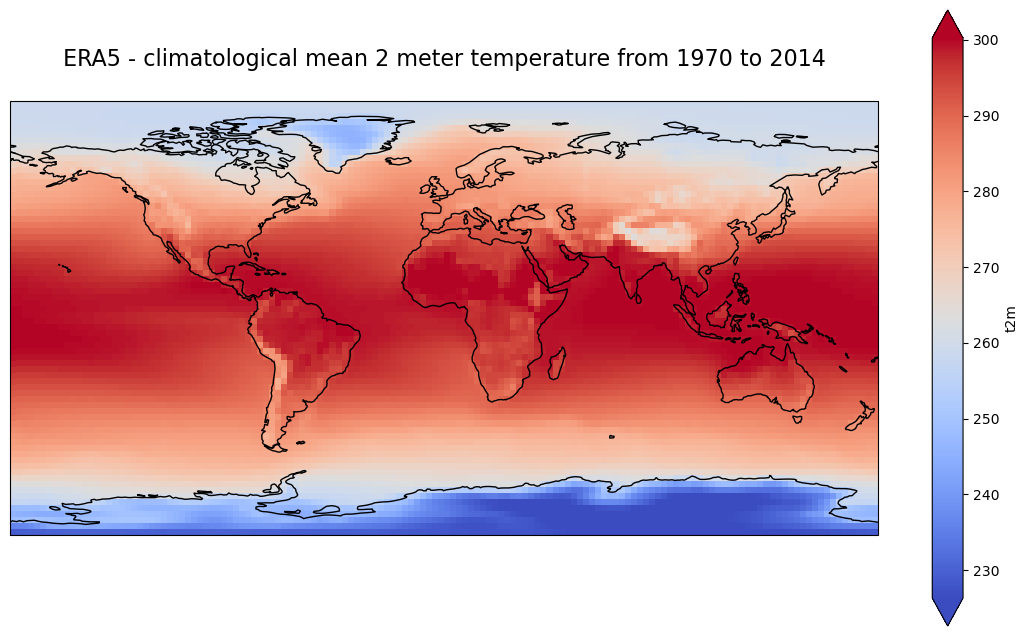

In [630]:
fig=plt.figure(figsize=(14,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ERA5_mean.plot.pcolormesh(ax=ax, cmap='coolwarm', robust=True)
ax.coastlines()
ax.set_title('\n ERA5 - climatological mean 2 meter temperature from 1970 to 2014 \n', fontsize=16)
plt.savefig("t2m_ERA5.pdf")

In [631]:
model = {"AWI_CM_1_1_MR" : AWI_CM_1_1_MR_mean,
        "CESM2" : CESM2_mean,
        "GFDL_CM4" : GFDL_CM4_mean,
        "MPI_ESM_1_2_HAM" : MPI_ESM_1_2_HAM_mean} 
model_name = list(model.keys())

In [632]:
def plot_models_fct(model,model_name):
    fig=plt.figure(figsize=(18,9))
    ax0 = plt.subplot2grid((2,2),(0,0),colspan=1,rowspan=1,projection=ccrs.PlateCarree())
    ax1 = plt.subplot2grid((2,2),(0,1),colspan=1,rowspan=1,projection=ccrs.PlateCarree())
    ax2 = plt.subplot2grid((2,2),(1,0),colspan=1,rowspan=1,projection=ccrs.PlateCarree())
    ax3 = plt.subplot2grid((2,2),(1,1),colspan=1,rowspan=1,projection=ccrs.PlateCarree())
    
    axes = [ax0,ax1,ax2,ax3]
    index = [0,1,2,3]
    
    for i,j in zip(axes,index):
        data = model[model_name[j]]
        #i.coastlines()
        data.plot.pcolormesh(ax = i, cmap='coolwarm', robust=True,label='T[K]',cbar_kwargs={'label':"Temperature [K]"})
        i.coastlines()
        i.set_extent([-160,160,-90,90])
        gl = i.gridlines(draw_labels = True)
        gl.xlabel_style = dict(fontsize=9)
        gl.ylabel_style = dict(fontsize=9,rotation=90,va='bottom',ha='center')
        gl.top_labels = False
        gl.right_labels = False
        i.set_title("mean 2 meter temperature 1970-2014 {} ".format(model_name[j]),fontsize=12)
        plt.savefig("t2m_models.pdf")

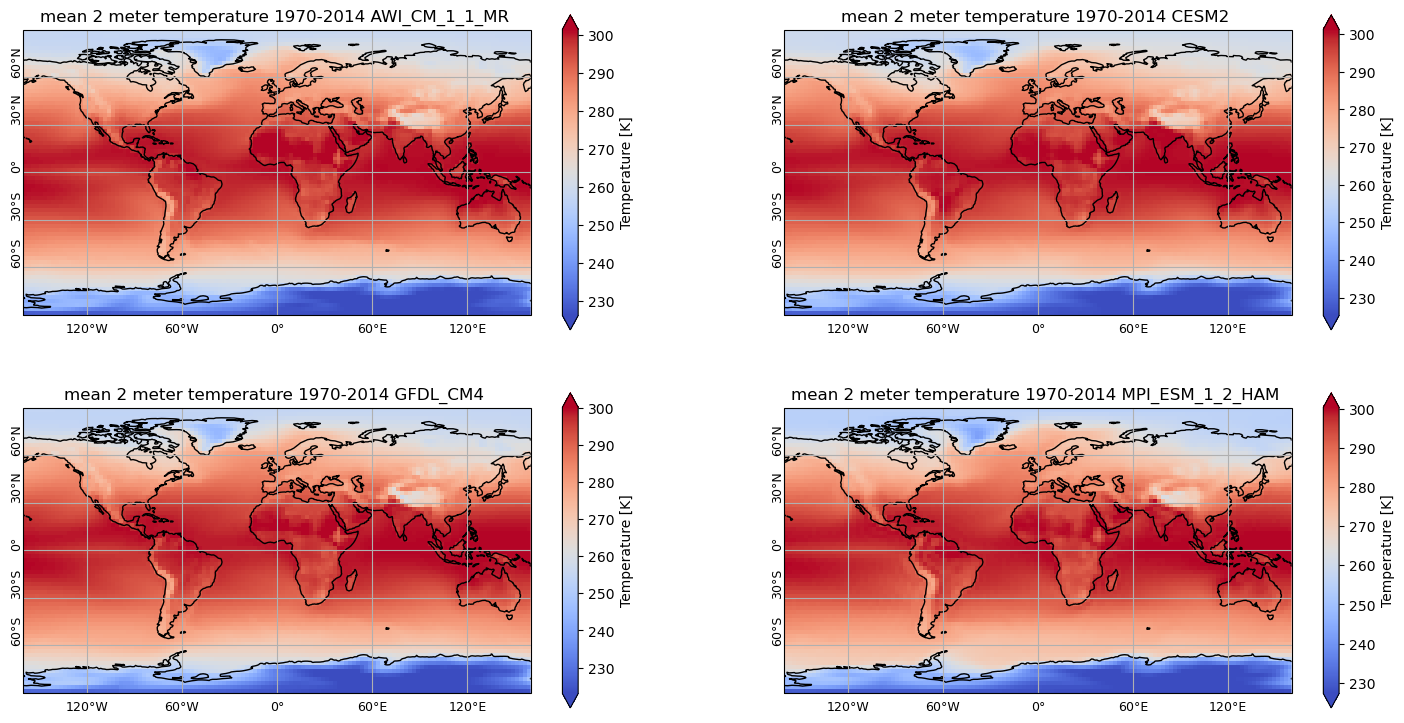

In [633]:
plot_models_fct(model,model_name)

In [634]:
#calculate the differences
AWI_CM_1_1_MR_diff = ERA5_mean - AWI_CM_1_1_MR_mean
CESM2_diff = ERA5_mean - CESM2_mean
GFDL_CM4_diff = ERA5_mean - GFDL_CM4_mean
MPI_ESM_1_2_HAM_diff = ERA5_mean - MPI_ESM_1_2_HAM_mean

In [635]:
model_diff = {"AWI_CM_1_1_MR" : AWI_CM_1_1_MR_diff,
        "CESM2" : CESM2_diff,
        "GFDL_CM4" : GFDL_CM4_diff,
        "MPI_ESM_1_2_HAM" : MPI_ESM_1_2_HAM_diff} 
model_name_diff = list(model_diff.keys())

In [637]:
def plot_differences_fct(model_diff,model_name_diff):
    fig=plt.figure(figsize=(18,9))
    ax0 = plt.subplot2grid((2,2),(0,0),colspan=1,rowspan=1,projection=ccrs.PlateCarree())
    ax1 = plt.subplot2grid((2,2),(0,1),colspan=1,rowspan=1,projection=ccrs.PlateCarree())
    ax2 = plt.subplot2grid((2,2),(1,0),colspan=1,rowspan=1,projection=ccrs.PlateCarree())
    ax3 = plt.subplot2grid((2,2),(1,1),colspan=1,rowspan=1,projection=ccrs.PlateCarree())
    
    axes = [ax0,ax1,ax2,ax3]
    index = [0,1,2,3]
    
    for i,j in zip(axes,index):
        data = model_diff[model_name_diff[j]]
        #i.coastlines()
        data.plot.pcolormesh(ax = i, cmap='coolwarm', robust=True,label='T[K]',cbar_kwargs={'label':"Temperature [K]"})
        i.coastlines()
        i.set_extent([-160,160,-90,90])
        gl = i.gridlines(draw_labels = True)
        gl.xlabel_style = dict(fontsize=9)
        gl.ylabel_style = dict(fontsize=9,rotation=90,va='bottom',ha='center')
        gl.top_labels = False
        gl.right_labels = False
        i.set_title("Difference ERA5 and {} ".format(model_name_diff[j]),fontsize=12)
        plt.savefig("Differences_models.pdf")

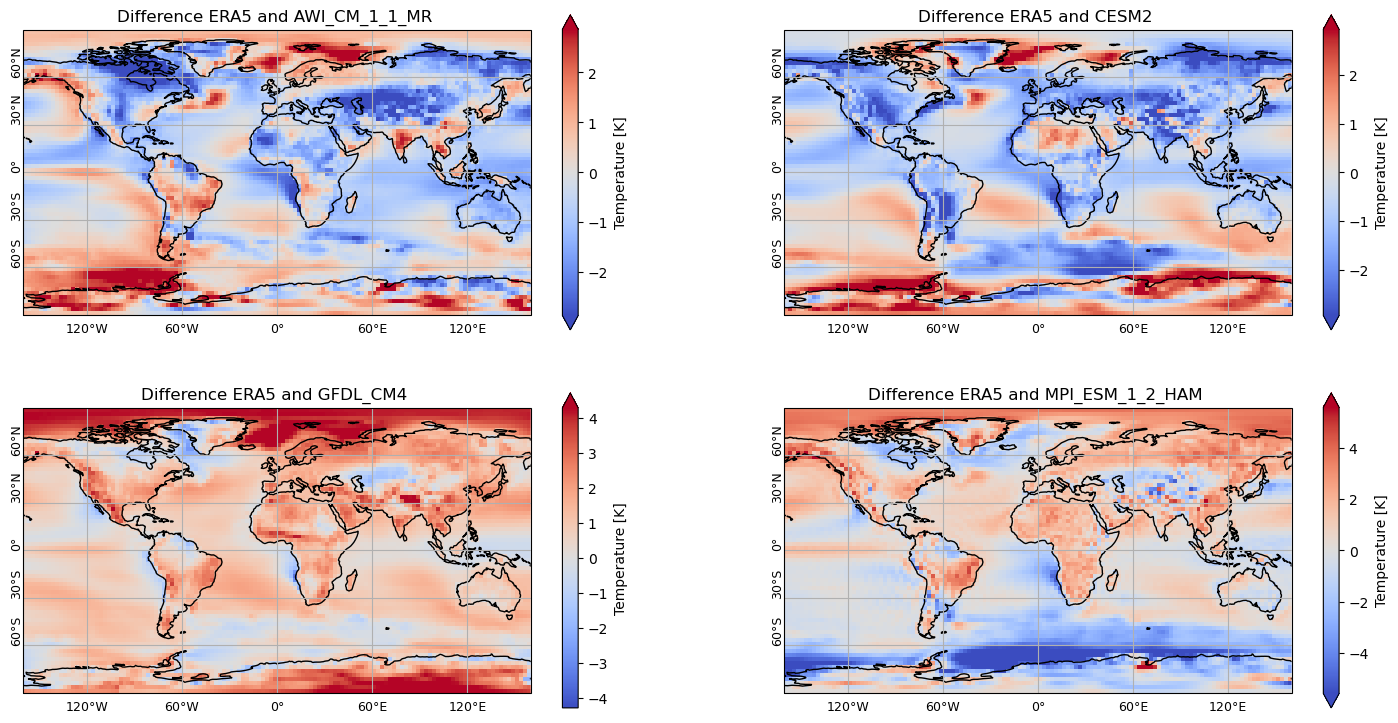

In [638]:
plot_differences_fct(model_diff,model_name_diff)

In [639]:
def calculate_global_mean_cos(ds):
    # NOTE: we use xarray here which is already a somewhat domain-specific 
    # Python package, in pure python this would be even more cumbersome

    # we need to know the name of the latitude and longtiude dimensions
    # so hardcode it here --> this will break for datasets with other names
    latn = 'lat'
    lonn = 'lon'

    # calculate weights to account for longitude convergence
    lats = ds[latn]
    weights_lat = np.cos(np.radians(lats))

    # calculate the area-weighted mean over latitude and longitude
    ds_mean = ds.weighted(weights_lat).mean(dim=[latn, lonn], keep_attrs=True)
    return ds_mean

In [640]:
#calculate mean of the differences
AWI_CM_1_1_MR_diff_mean = calculate_global_mean_cos(AWI_CM_1_1_MR_diff)
CESM2_diff_mean = calculate_global_mean_cos(CESM2_diff)
GFDL_CM4_diff_mean = calculate_global_mean_cos(GFDL_CM4_diff)
MPI_ESM_1_2_HAM_diff_mean = calculate_global_mean_cos(MPI_ESM_1_2_HAM_diff)

### Indicate the RMSE {-}

$$ RMSE = \sqrt{ \Sigma \frac{(x -\widehat{x})^2}{n}} $$

In [641]:
#define function for the calculation of of the RMSE
def RMSE(x,y):
    return calculate_global_mean_cos(np.sqrt(np.square(np.subtract(x,y))))

In [642]:
#RMSE of Difference!
RMSE_AWI_CM_1_1_MR = RMSE(AWI_CM_1_1_MR_diff,AWI_CM_1_1_MR_diff_mean)
RMSE_CESM2 = RMSE(CESM2_diff,CESM2_diff_mean)
RMSE_GFDL_CM4 = RMSE(GFDL_CM4_diff,GFDL_CM4_diff_mean)
RMSE_MPI_ESM_1_2_HAM = RMSE(MPI_ESM_1_2_HAM_diff,MPI_ESM_1_2_HAM_diff_mean)

print('RMSE of ERA5 and AWI_CM_1_1_MR is:', RMSE_AWI_CM_1_1_MR.values.round(4))
print('RMSE of ERA5 and CESM2 is:', RMSE_CESM2.values.round(4))
print('RMSE of ERA5 and GFDL_CM4 is:', RMSE_GFDL_CM4.values.round(4))
print('RMSE of ERA5 and MPI_ESM_1_2_HAM is:', RMSE_MPI_ESM_1_2_HAM.values.round(4))

RMSE of ERA5 and AWI_CM_1_1_MR is: 0.85
RMSE of ERA5 and CESM2 is: 0.8622
RMSE of ERA5 and GFDL_CM4 is: 0.7475
RMSE of ERA5 and MPI_ESM_1_2_HAM is: 1.2356


### Indicate the bias {-}

$$ bias = x - \overline{x}$$

In [643]:
#Bias of Difference!
bias_AWI_CM_1_1_MR = AWI_CM_1_1_MR_diff-AWI_CM_1_1_MR_diff_mean
bias_CESM2 = CESM2_diff-CESM2_diff_mean
bias_GFDL_CM4 = GFDL_CM4_diff-GFDL_CM4_diff_mean
bias_MPI_ESM_1_2_HAM = MPI_ESM_1_2_HAM_diff-MPI_ESM_1_2_HAM_diff_mean

In [644]:
model_bias = {"AWI_CM_1_1_MR" : bias_AWI_CM_1_1_MR,
        "CESM2" : bias_CESM2,
        "GFDL_CM4" : bias_GFDL_CM4,
        "MPI_ESM_1_2_HAM" : bias_MPI_ESM_1_2_HAM} 
model_name_bias= list(model_bias.keys())

In [646]:
def plot_bias_fct(model_bias,model_name_bias):
    fig=plt.figure(figsize=(18,9))
    ax0 = plt.subplot2grid((2,2),(0,0),colspan=1,rowspan=1,projection=ccrs.PlateCarree())
    ax1 = plt.subplot2grid((2,2),(0,1),colspan=1,rowspan=1,projection=ccrs.PlateCarree())
    ax2 = plt.subplot2grid((2,2),(1,0),colspan=1,rowspan=1,projection=ccrs.PlateCarree())
    ax3 = plt.subplot2grid((2,2),(1,1),colspan=1,rowspan=1,projection=ccrs.PlateCarree())
    
    axes = [ax0,ax1,ax2,ax3]
    index = [0,1,2,3]
    
    for i,j in zip(axes,index):
        data = model_bias[model_name_bias[j]]
        #i.coastlines()
        data.plot.pcolormesh(ax = i, cmap='coolwarm', robust=True,label='T[K]',cbar_kwargs={'label':"Temperature [K]"})
        i.coastlines()
        i.set_extent([-160,160,-90,90])
        gl = i.gridlines(draw_labels = True)
        gl.xlabel_style = dict(fontsize=9)
        gl.ylabel_style = dict(fontsize=9,rotation=90,va='bottom',ha='center')
        gl.top_labels = False
        gl.right_labels = False
        i.set_title("Bias of the Difference of ERA5 and {} ".format(model_name_bias[j]),fontsize=12)
        plt.savefig("Bias.pdf")

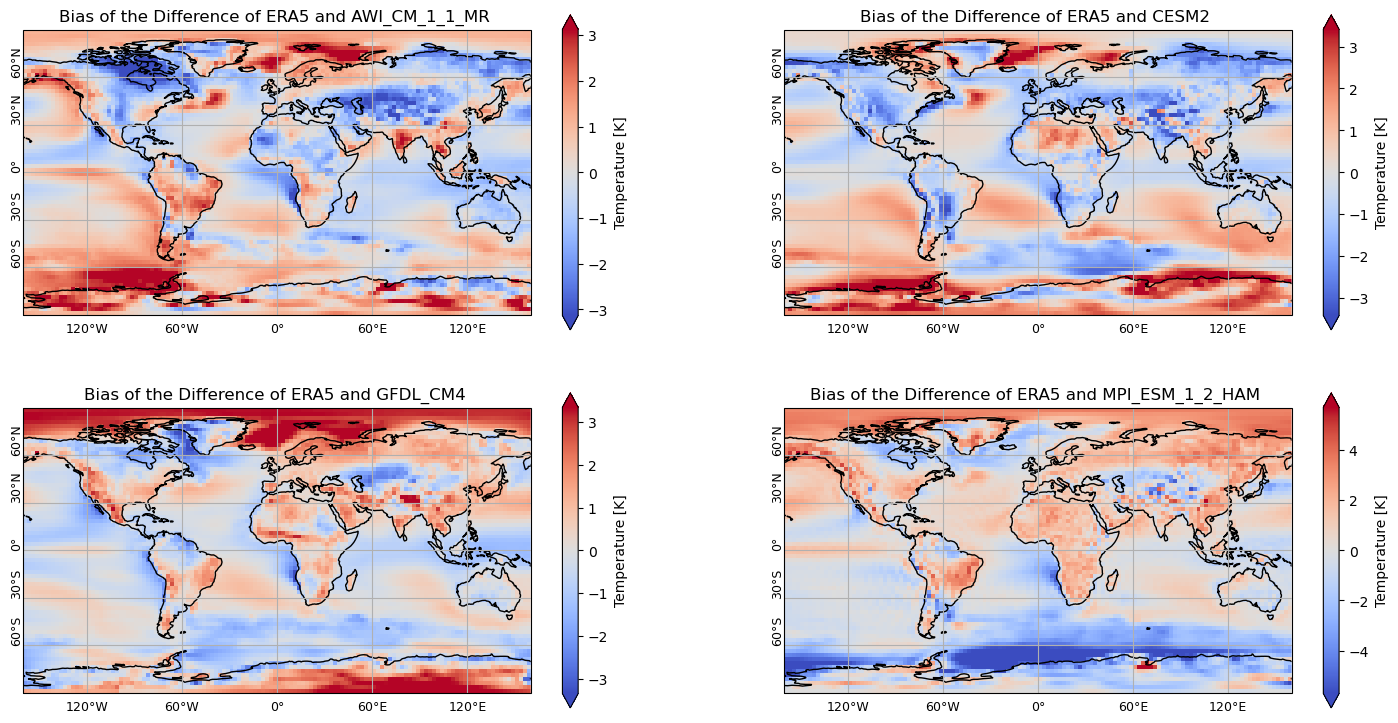

In [647]:
plot_bias_fct(model_bias,model_name_bias)

### Put the plotting routine in a function and document it with a docstring. Then put it in a .py file. To show the plots, import the function in a notebook or another .py file and use it there.

In [648]:
import function_plot_ex3 as plots_EX3

In [649]:
print(plots_EX3.EXTRA_plot_models_fct.__doc__)

Function to plot four (and only four!) climate models in a subplot


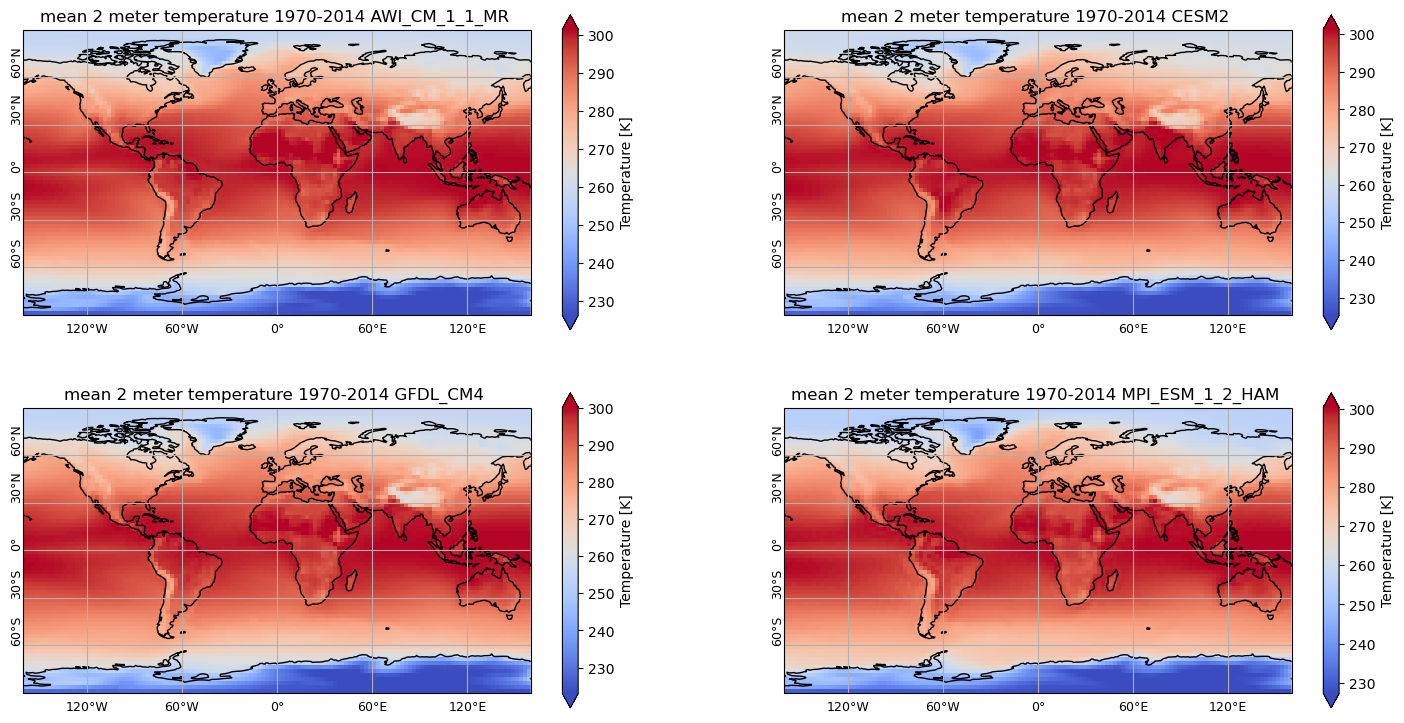

In [650]:
plots_EX3.EXTRA_plot_models_fct(model, model_name)

#### Commit the plotting function to your new git repository {-}

In [651]:
#I uploaded it in Github!

``` bash

git clone git@github.com:a11920398/Modelling_UE.git
cd Modelling_UE
git branch

```

``` bash
git config --global user.name "a11920398"
git init
git status
git add /users/students/a11920398/MODELLING/UE/function_plot_ex3.py
git commit -m "creating function_plot_ex3.py"
git push -u origin Exercise_3
git log
```

---

#### 3) Principal component analysis {-}
Perform a principal component analysis on the annual mean temperature (1950-2022) from
ERA5 and/or CMIP6, treating each grid point as a separate ”station”. Focus on a specific
region of interest (e.g., Tropical Pacific, North Atlantic, Europe). Plot the resulting first four
loadings using the map plotting function from Example 2. Do the loadings reflect any familiar
oscillations?
Hint 1: To select a region you can crop the dataset using the following command (if it is an
Xarray dataset):

ds_crop = ds.sel(latitude=slice(lat0,lat1), longitude=slice(lon0,lon1))

In [671]:
ERA5 = xr.open_dataset("/users/students/a11920398/MODELLING/UE/ERA5_EX3.nc")
print('Time:', ERA5['time'].shape)
print('Longitude:', ERA5['lon'].shape)
print('Latitude:', ERA5['lat'].shape)

Time: (864,)
Longitude: (144,)
Latitude: (72,)


In [672]:
def calculate_annual_mean(ds):
    # we need the name of the time dimension
    timen = 'time'
    
    def _wmean(ds):
        days_in_month = ds[timen].dt.days_in_month
        weights_month = days_in_month / days_in_month.sum()
        ds_mean = ds.weighted(weights_month).mean(dim=timen, keep_attrs=True)
        return ds_mean
    
    ds_mean = ds.groupby('time.year').apply(_wmean)
    return ds_mean

In [673]:
ERA5_annual_mean = calculate_annual_mean(ERA5['t2m'])
print('Shape of annual time:', ERA5_annual_mean.shape[0])

Shape of annual time: 72


In [674]:
ERA5_timemean_withlonlat = np.mean(ERA5['t2m'],axis=0)

In [675]:
ERA_global_mean = ERA5_annual_mean.mean('year')

In [676]:
#define meshgrid!

#arange for lat
ERA5['lat']
np.arange(-88.75,91.25,2.5)
np.arange(-88.75,91.25,2.5).shape

#arange for lon
ERA5['lon']
np.arange(1.25,361.25,2.5)
np.arange(1.25,361.25,2.5).shape

xx, yy = np.meshgrid(np.arange(1.25,361.25,2.5),np.arange(-88.75,91.25,2.5))

In [677]:
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

In [678]:
x = np.arange(1.25,361.25,2.5)
y = np.arange(-88.75,91.25,2.5)

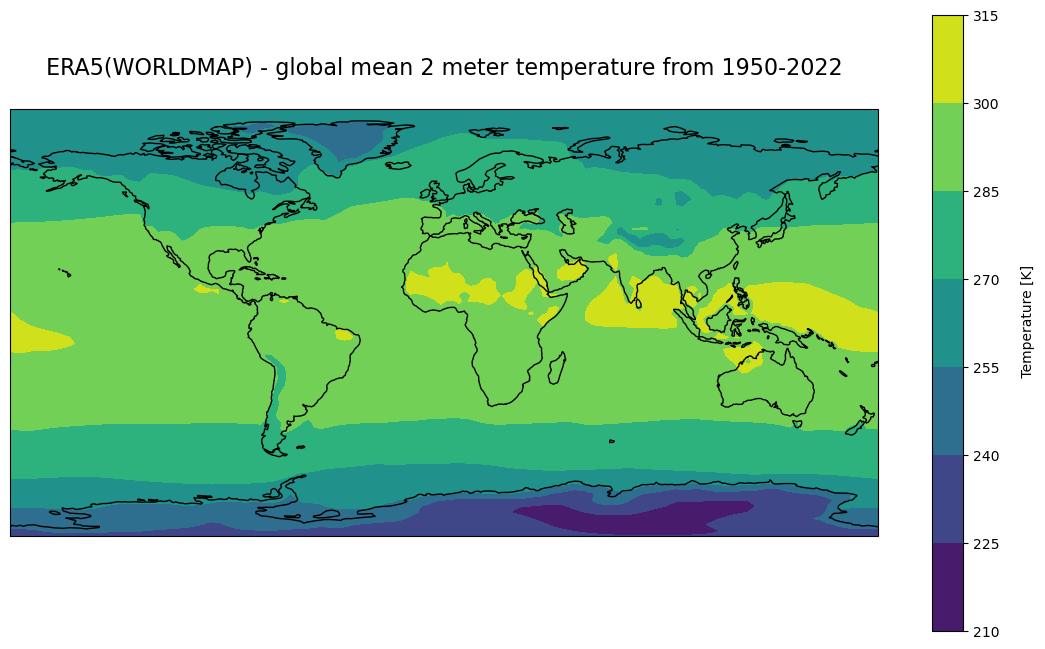

In [679]:
#1. Variante --> falls es nicht funktioniert nochmal ERA5_timemean_withlonlat asuführen
fig=plt.figure(figsize=(14,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ERA5_timemean_withlonlat, x = add_cyclic_point(ERA5_timemean_withlonlat, coord = x)
plt.contourf(x, y,ERA5_timemean_withlonlat)
plt.colorbar(label='\n Temperature [K]')
ax.coastlines()
ax.set_title('\n ERA5(WORLDMAP) - global mean 2 meter temperature from 1950-2022 \n', fontsize=16)
plt.savefig("TASK3_t2m.pdf")

Text(0.5, 1.0, '\n ERA5 (WORLDMAP) - global mean 2 meter temperature from 1950-2022 \n')

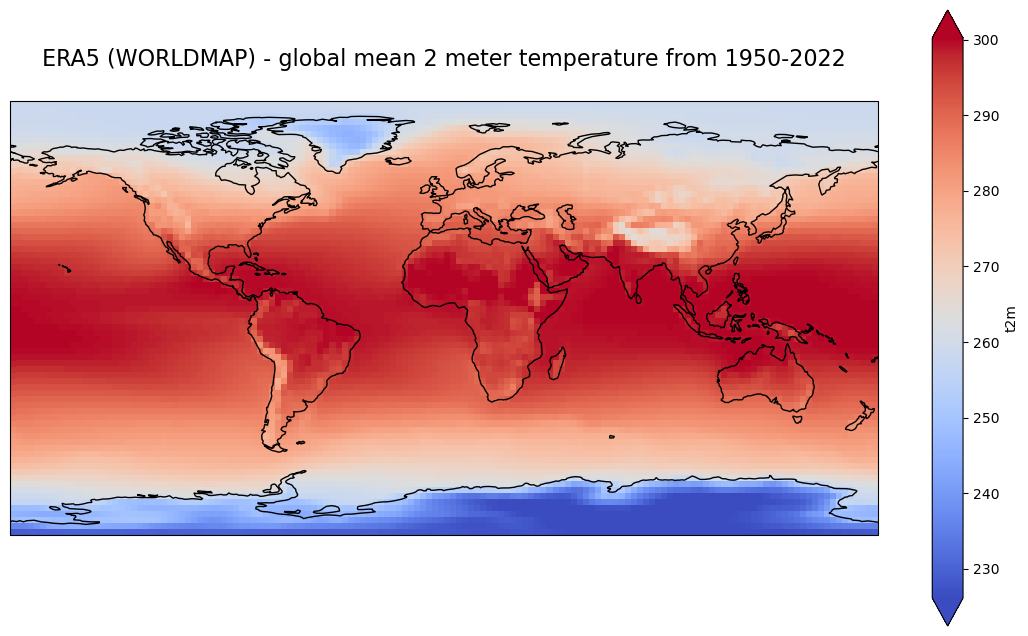

In [680]:
#2. Variante
fig=plt.figure(figsize=(14,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ERA_global_mean.plot.pcolormesh(ax=ax, cmap='coolwarm', robust=True)
ax.coastlines()
ax.set_title('\n ERA5 (WORLDMAP) - global mean 2 meter temperature from 1950-2022 \n', fontsize=16)

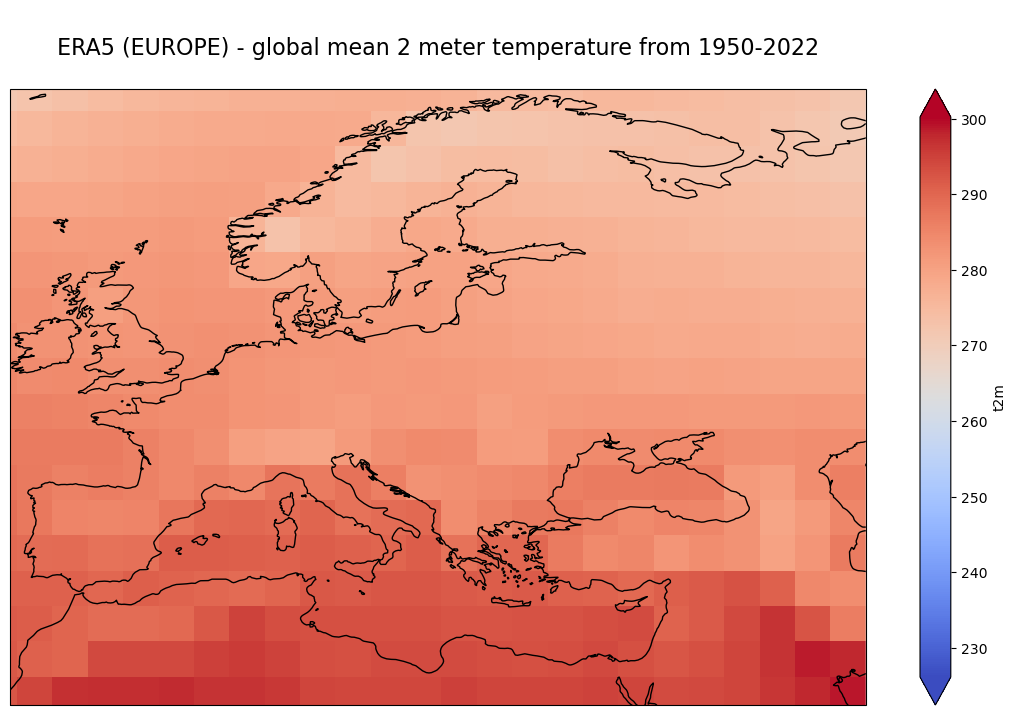

In [681]:
#Europe
#lat = 34° North and 81° North
#lon = 31° West and 69° East
fig=plt.figure(figsize=(14,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ERA_global_mean.plot.pcolormesh(ax=ax, cmap='coolwarm', robust=True)
ax.coastlines()
ax.set_title('\n ERA5 (EUROPE) - global mean 2 meter temperature from 1950-2022 \n', fontsize=16)
ax.set_extent([-10.5, 50, 28, 69])

### Calculate PCA worldwide {-}

In [682]:
pca = PCA()

In [683]:
ERA5_annual_mean.shape

(72, 72, 144)

In [684]:
pca.fit(np.reshape(ERA5_annual_mean.values,(ERA5_annual_mean['year'].shape[0],10368))) #10368 = 72*144

PCA()

In [685]:
from sklearn.decomposition import PCA 

In [690]:
eigenvalues = pca.explained_variance_
loadings = pca.components_ #loadings sollte (72, 72*144)=(72,10368) sein!
scores = pca.transform(np.reshape(ERA5_annual_mean.values,(ERA5_annual_mean['year'].shape[0],10368))) 

print('Shape of eigenvalues:', eigenvalues.shape)
print('Shape of loadings:', loadings.shape)
print('Shape of scores:', scores.shape)

Shape of eigenvalues: (72,)
Shape of loadings: (72, 10368)
Shape of scores: (72, 72)


In [691]:
x = np.arange(1.25,361.25,2.5)
y = np.arange(-88.75,91.25,2.5)

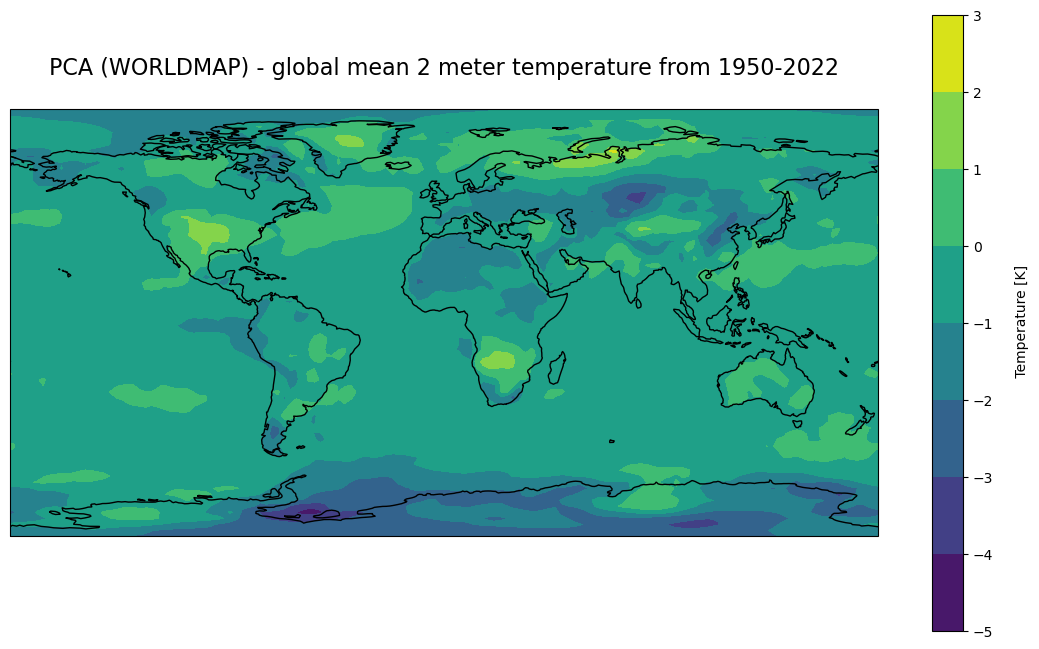

In [692]:
#PCA plot for the whole world
len_loadings = 4 #Plot the resulting first four loadings
pcana = np.zeros(np.shape(loadings))
for k in range(np.shape(pcana)[0]):
    for i in range(72):
        pcana[k] = pcana[k] + scores[k][i]*loadings[i]

pcana= np.reshape(pcana,(72,72,144))


fig=plt.figure(figsize=(14,8))
ax = plt.axes(projection=ccrs.PlateCarree())
pcana, x = add_cyclic_point(pcana, coord = x)
plt.contourf(x, y,pcana[4])
plt.colorbar(label='\n Temperature [K]')
ax.coastlines()
ax.set_title('\n PCA (WORLDMAP) - global mean 2 meter temperature from 1950-2022 \n', fontsize=16)
plt.savefig("PCA_worldwide.pdf")

### Calculate PCA for Asia {-}

In [737]:
#Asia
min_lon = 11.25 #233.75 #251.25
min_lat = 6.25 #21.25
max_lon = 171.25 #311.25
max_lat = 86.25 #51.25 #da 180+69East

ds_crop = ERA5_annual_mean.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))
#ds_crop

In [738]:
ds_crop = ERA5_annual_mean.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))
#ds_crop

In [739]:
np.shape(ds_crop)

(72, 33, 65)

In [740]:
pca.fit(np.reshape(ds_crop.values,(ds_crop['year'].shape[0], 2145))) #2145 = 33*65

PCA()

In [741]:
eigenvalues = pca.explained_variance_
loadings = pca.components_ #loadings sollten (72, 33*65)=(72,2145) sein!
scores = pca.transform(np.reshape(ds_crop.values,(ds_crop['year'].shape[0], 2145))) 
print('Shape of eigenvalues:', eigenvalues.shape)
print('Shape of loadings:', loadings.shape)
print('Shape of scores:', scores.shape)

Shape of eigenvalues: (72,)
Shape of loadings: (72, 2145)
Shape of scores: (72, 72)


In [742]:
x = np.arange(min_lon , max_lon+2.5, 2.5)
y = np.arange(min_lat , max_lat+2.5, 2.5)

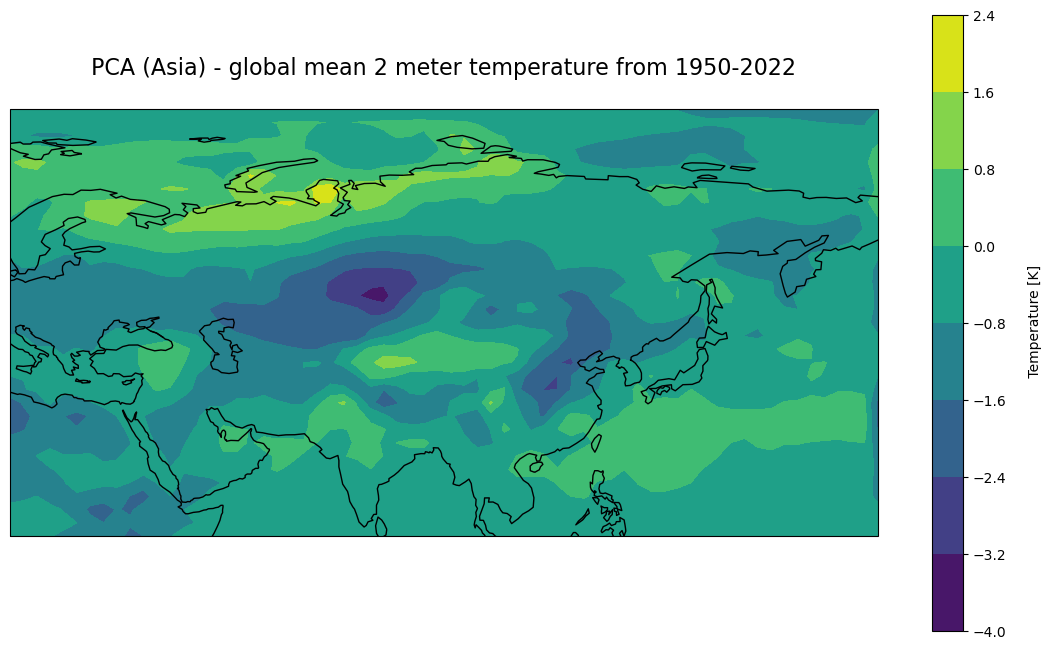

In [743]:
#for Asia
len_loadings = 4 #Plot the resulting first four loadings
pcana = np.zeros(np.shape(loadings))
for k in range(np.shape(pcana)[0]):
    for i in range(72):
        pcana[k] = pcana[k] + scores[k][i]*loadings[i]

pcana= np.reshape(pcana,(72,33,65))


fig=plt.figure(figsize=(14,8))
ax = plt.axes(projection=ccrs.PlateCarree())
pcana, x = add_cyclic_point(pcana, coord = x)
plt.contourf(x, y,pcana[4]) #pcana[4] plot first 4 loadings
plt.colorbar(label='\n Temperature [K]')
ax.coastlines()
ax.set_title('\n PCA (Asia) - global mean 2 meter temperature from 1950-2022 \n', fontsize=16)
plt.savefig("PCA_Asia.pdf")

### Plot the resulting first four loadings (Asia){-}

In [768]:
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

In [769]:
loadings = np.reshape(loadings,(72,33,65))

In [770]:
def plot_loadings_fct(x, y, loadings):
    fig = plt.figure(figsize = (15,7))
    ax0 = plt.subplot2grid((2, 2), (0, 0), colspan=1, rowspan=1, projection=ccrs.PlateCarree())
    ax1 = plt.subplot2grid((2, 2), (0, 1), colspan=1, rowspan=1, projection=ccrs.PlateCarree())
    ax2 = plt.subplot2grid((2, 2), (1, 0), colspan=1, rowspan=1, projection=ccrs.PlateCarree())
    ax3 = plt.subplot2grid((2, 2), (1, 1), colspan=1, rowspan=1, projection=ccrs.PlateCarree())

    axes = [ax0, ax1, ax2, ax3]
    index = [0,1,2,3]
    

    for i,j in zip(axes, index):
        loadings, x = add_cyclic_point(loadings, coord = x)
        cs = i.contourf(x, y, loadings[j])
        fig.colorbar(cs, ax = i, shrink=0.9, label=' Loading {}'.format(j + 1))
        i.coastlines()
        i.set_title('Loading {} (ASIA) global mean 2m Temp'.format(j + 1), fontsize=16)
        plt.savefig("Loadings_Asia.pdf")

In [771]:
x = np.arange(min_lon , max_lon+2.5, 2.5)
y = np.arange(min_lat , max_lat+2.5, 2.5)

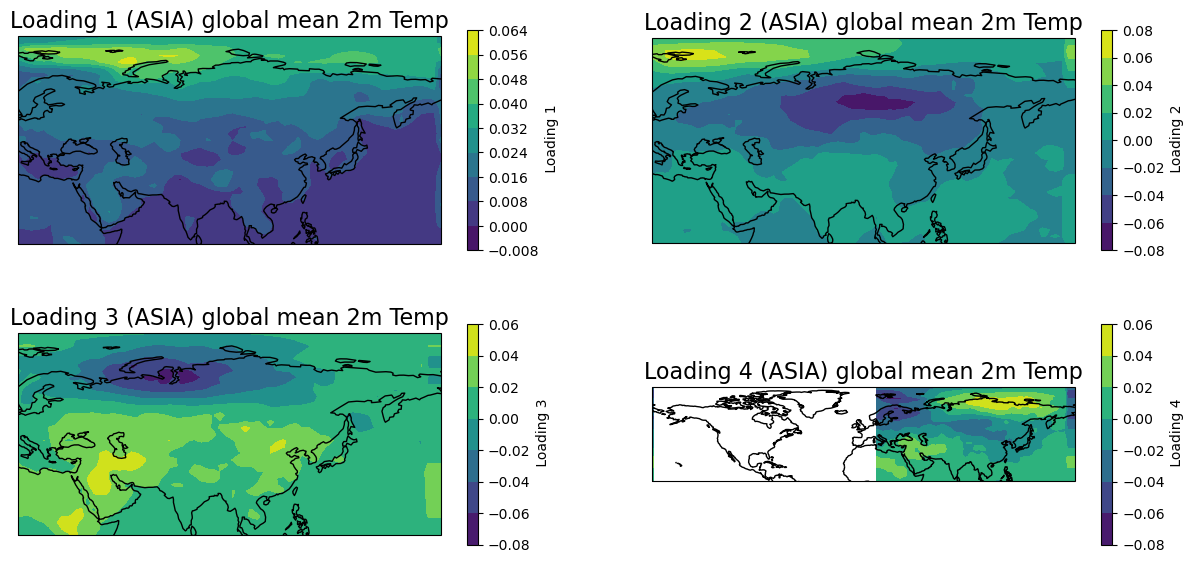

In [772]:
plot_loadings_fct(x, y, loadings)

#### Do the loadings reflect any familiar oscillations? {-}

In [773]:
loadings = pca.components_

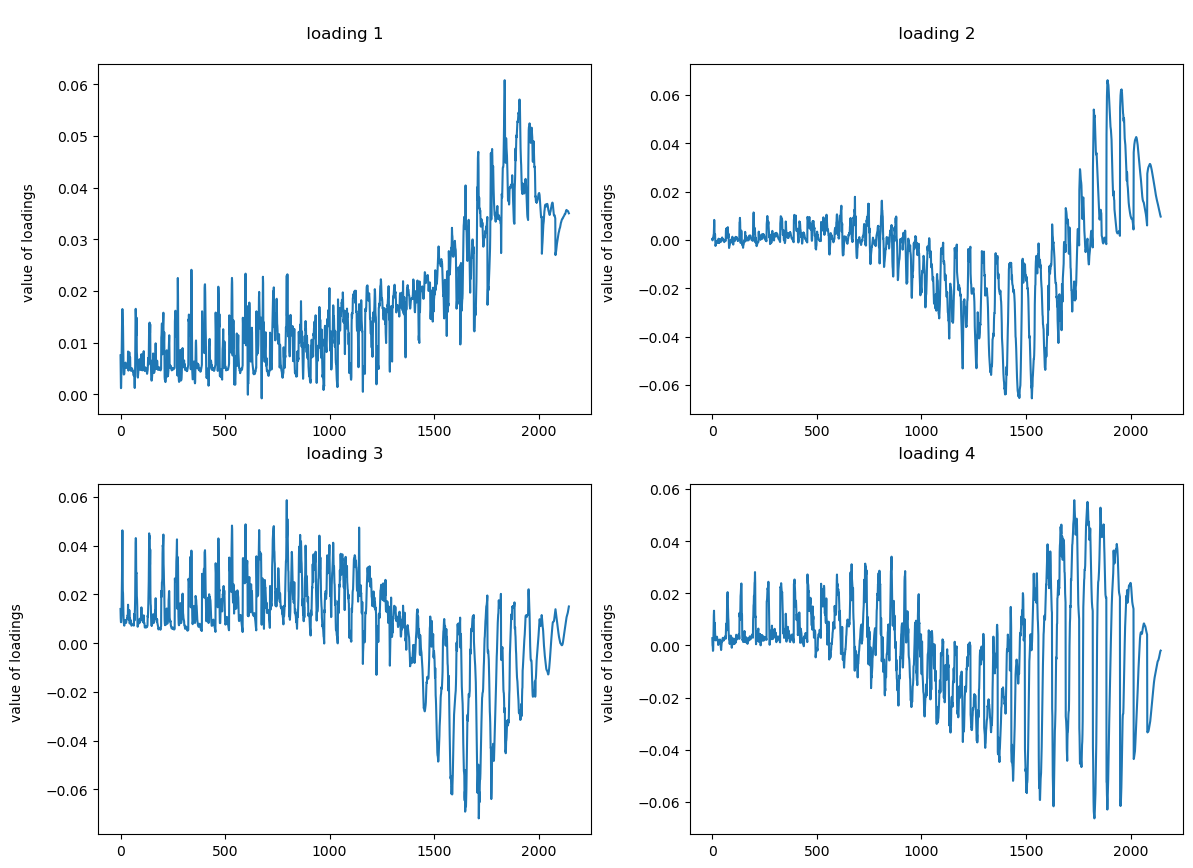

In [774]:
fig, axs = plt.subplots(2,2)
fig.set_figheight(10)
fig.set_figwidth(14)

#loading 1
axs[0,0].plot(loadings[0])
axs[0,0].set_ylabel('value of loadings \n')
axs[0,0].set_title('\n loading 1 \n')

#loading 2
axs[0,1].plot(loadings[1])
axs[0,1].set_ylabel('value of loadings \n')
axs[0,1].set_title('\n loading 2 \n')

#loading 3
axs[1,0].plot(loadings[2])
axs[1,0].set_ylabel('value of loadings \n')
axs[1,0].set_title('\n loading 3 \n')

#loading 4
axs[1,1].plot(loadings[3])
axs[1,1].set_ylabel('value of loadings \n')
axs[1,1].set_title('\n loading 4 \n')

plt.savefig("oscillations.pdf")

### Additional plots for PCA (WORLDWIDE) {-}

In [713]:
pca.fit(np.reshape(ERA5_annual_mean.values,(ERA5_annual_mean['year'].shape[0],10368))) #10368 = 72*144

eigenvalues = pca.explained_variance_
loadings = pca.components_ #loadings sollte (72, 72*144)=(72,10368) sein!
scores = pca.transform(np.reshape(ERA5_annual_mean.values,(ERA5_annual_mean['year'].shape[0],10368))) 

print('Shape of eigenvalues:', eigenvalues.shape)
print('Shape of loadings:', loadings.shape)
print('Shape of scores:', scores.shape)

Shape of eigenvalues: (72,)
Shape of loadings: (72, 10368)
Shape of scores: (72, 72)


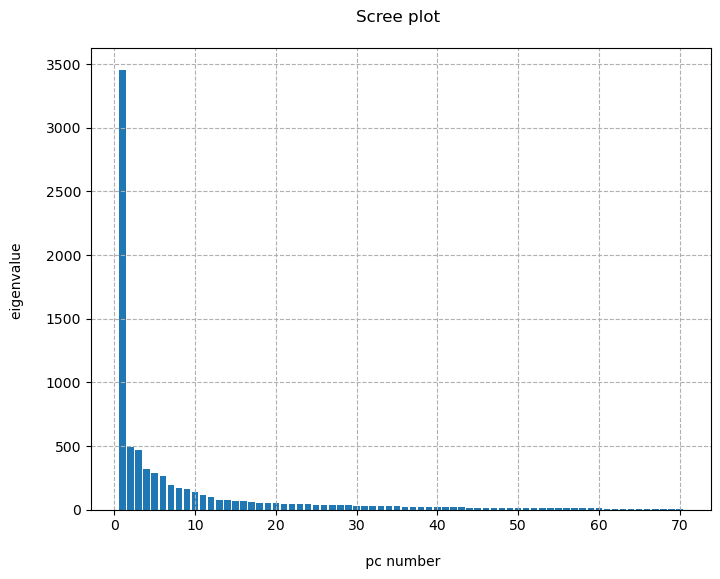

In [714]:
L=70
plt.figure(figsize=(8,6))
plt.grid(ls='--')
plt.bar(np.arange(1,L+1), eigenvalues[:L])
plt.xlabel('\n pc number')
plt.ylabel('eigenvalue \n')
plt.title('Scree plot \n')
plt.savefig("Scree_plot.pdf")

In [715]:
len_loadings = 4
pcana = np.zeros(np.shape(loadings))
for k in range(np.shape(pcana)[0]): #k = number of rows
    for j in range(72): #j = number of columns
        pcana[k] = pcana[k] + scores[k][j]*loadings[j]

pcana= np.reshape(pcana,(72,72,144))

#### Plot of the annual mean temperatures (original/reconstructed) for VIENNA {-}

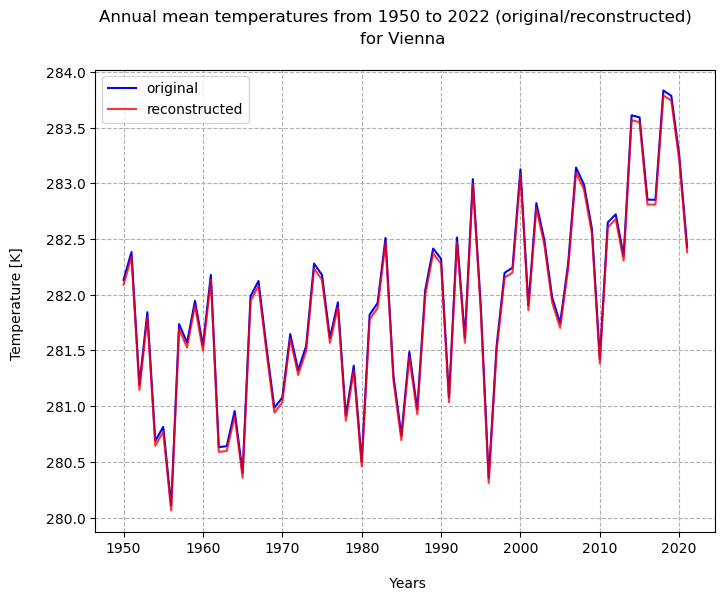

In [716]:
#Vienna coordinates: 
#lat=48.2 --> ERA5_annual_mean['lat'][55]
#lon=16.3 --> ERA5_annual_mean['lon'][6]
plt.figure(figsize=(8,6))
plt.grid(ls='--')
plt.xlabel('\n Years')
plt.ylabel('Temperature [K] \n')
plt.suptitle('Annual mean temperatures from 1950 to 2022 (original/reconstructed)\n')
plt.title('for Vienna \n')
ticks=[0,10,20,30,40,50,60,70]
labels=[i+1950 for i in ticks]
plt.xticks(ticks,labels)
plt.plot(ERA5_annual_mean[:,55,6], label='original',c='b',alpha=0.99)
plt.plot(pcana[:,55,6] + float(ERA5_timemean_withlonlat[55,6]), label='reconstructed',c='r',alpha=0.8)
plt.legend()
plt.savefig("original_reconstructed_VIENNA.pdf")

#### Plot of the annual mean temperatures (original/reconstructed) for JAPAN {-}

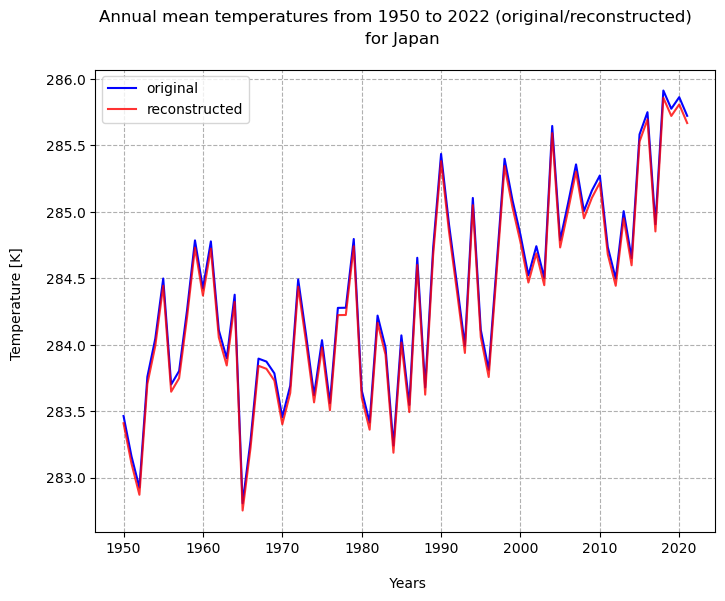

In [718]:
#Japan coordinates: 
#lat=36.2 --> ERA5_annual_mean['lat'][50]
#lon=139.8 --> ERA5_annual_mean['lon'][55]
plt.figure(figsize=(8,6))
plt.grid(ls='--')
plt.xlabel('\n Years')
plt.ylabel('Temperature [K] \n')
plt.suptitle('Annual mean temperatures from 1950 to 2022 (original/reconstructed)\n')
plt.title('for Japan \n')
ticks=[0,10,20,30,40,50,60,70]
labels=[i+1950 for i in ticks]
plt.xticks(ticks,labels)
plt.plot(ERA5_annual_mean[:,50,55], label='original',c='b',alpha=0.99)
plt.plot(pcana[:,50,55] + float(ERA5_timemean_withlonlat[50,55]), label='reconstructed',c='r',alpha=0.8)
plt.legend()
plt.savefig("original_reconstructed_JAPAN.pdf")

---

#### 4) Unit testing {-}
Use the NumPy testing framework to test whether the dataset reconstructed from the principal
component loadings and scores computed in Example 3 is equal to the original dataset. Use the
function testing.assert_allclose() to allow for rounding errors up to a tolerance level.

In [719]:
#for Vienna
np.testing.assert_allclose(ERA5_annual_mean[:,55,6],pcana[:,55,6] + float(ERA5_timemean_withlonlat[55,6]),rtol=1e-3)

##### --> works for rtol=0.001! {-}

In [720]:
#for Japan
np.testing.assert_allclose(ERA5_annual_mean[:,50,55],pcana[:,50,55] + float(ERA5_timemean_withlonlat[50,55]),rtol=1e-3)

##### --> also works only for rtol=0.001! {-}

---

#### 5) Publication of your code on GitHub {-}
Fill your online repository by adding the plots and scripts you got in the previous sub-tasks.
Before that check your code style and be sure that it passes flake8 without issues. Describe all
files in the repository in the README file. Then make the repository public or invite Daria as
a collaborator (daria.tatsii@univie.ac.at)

```bash 
pip install flake8
cd /users/students/a11920398/MODELLING/UE
flake8 3_Exercise.ipynb
```

Code is fine except that I have very often more than 79 characters per line!

---